# Einstein-Bianchi equations

using 
* hyperbolic evolution for the divergence constraint
* iterative solvers for all three mass matrices


$$
\frac{d}{dt} \left( \begin{array}{c} E \\ v \\ H \end{array} \right) = 
\left( \begin{array}{ccc} 
 & & C^T \\
 & & D \\
 -C & -D^T & 
\end{array} \right)
\left( \begin{array}{c} E \\ v \\ H \end{array} \right) 
$$

In [1]:
from ngsolve import *
from ngsolve.webgui import Draw
mesh = Mesh(unit_cube.GenerateMesh(maxh=0.1))

In [2]:
n = specialcf.normal(3)

def CurlTHcc2Hcd(E,dH):
    return InnerProduct(curl(E).trans, dH)*dx \
       +InnerProduct(Cross(E*n, n), dH*n)*dx(element_boundary= True)
def DivHcdHd(B,dv):
    return div(B)*dv*dx - B*n*n * dv*n * dx(element_boundary= True)

In [3]:
order = 2

fescc = HCurlCurl(mesh, order=order)
fescd = HCurlDiv(mesh, order=order)
fesd = HDiv(mesh, order=order, RT=True)

E, dE = fescc.TnT()
v, dv = fesd.TnT()
B, dB = fescd.TnT()

In [4]:
bfcurlT = BilinearForm(CurlTHcc2Hcd(E, dB)).Assemble()
bfdiv = BilinearForm(DivHcdHd(B, dv)).Assemble()

In [5]:
massE = BilinearForm(InnerProduct(E,dE)*dx, condense=True)
preE = Preconditioner(massE, "bddc", block=True, blocktype="edgepatch")
massE.Assemble()
matE = massE.mat
# preE = matE.CreateBlockSmoother(fescc.CreateSmoothingBlocks(blocktype="edgepatch", eliminate_internal=True), GS=False)

massEinvSchur = CGSolver (matE, preE)
ext = IdentityMatrix()+massE.harmonic_extension
extT = IdentityMatrix()+massE.harmonic_extension_trans
massEinv =  ext @ massEinvSchur @ extT + massE.inner_solve
    

In [6]:
massB = BilinearForm(InnerProduct(B,dB)*dx, condense=True)
preB = Preconditioner(massB, "bddc", block=True, blocktype="edgepatch")
massB.Assemble()
matB = massB.mat    

# preH = matH.CreateSmoother(fescd.FreeDofs(True), GS=False)

massBinvSchur = CGSolver (matB, preB)
ext = IdentityMatrix()+massB.harmonic_extension
extT = IdentityMatrix()+massB.harmonic_extension_trans
massBinv =  ext @ massBinvSchur @ extT + massB.inner_solve

In [7]:
massv = BilinearForm(InnerProduct(v,dv)*dx, condense=True).Assemble()
matv = massv.mat
prev = matv.CreateSmoother(fesd.FreeDofs(True), GS=False)

massvinvSchur = CGSolver (matv, prev)
ext = IdentityMatrix()+massv.harmonic_extension
extT = IdentityMatrix()+massv.harmonic_extension_trans
massvinv =  ext @ massvinvSchur @ extT + massv.inner_solve

from ngsolve.la import EigenValues_Preconditioner
print (EigenValues_Preconditioner(matv, prev).NumPy())

[0.3257949  0.35666375 0.4001852  0.4546468  0.52096542 0.59632293
 0.68327291 0.78066327 0.89053594 0.99887391 1.11918535 1.24094956
 1.37073042 1.4994995  1.62861531 1.75784143 1.88864073 2.00437623
 2.12983877 2.23229853 2.3351803  2.4268745  2.46962603 2.54886727
 2.60785301]


exact inverses for testing:

In [8]:
# massE = BilinearForm(InnerProduct(E,dE)*dx).Assemble()
# massEinv = massE.mat.Inverse(inverse="sparsecholesky")

# massH = BilinearForm(InnerProduct(H,dH)*dx).Assemble()
# massHinv = massH.mat.Inverse(inverse="sparsecholesky")

# massv = BilinearForm(InnerProduct(v,dv)*dx).Assemble()
# massvinv = massv.mat.Inverse(inverse="sparsecholesky")

In [9]:
gfE = GridFunction(fescc)
gfB = GridFunction(fescd)
gfv = GridFunction(fesd)

In [30]:
# initial conditions ....
gfB.vec[:] = 0.0
gfE.vec[:] = 0.0
gfv.vec[:] = 0.0

peak = exp(-((x-0.5)**2+(y-0.5)**2+(z-0.5)**2)/ 2 )
gfE.Set ( ((peak, 0,0), (0,0,0), (0,0,-peak) ))
gfB.Set ( ((0,0,-peak), (0,0,0), (-peak,0,0) ))

In [31]:
t = 0
tend = 1
dt = 0.01
# tend = 5 * dt
#scene = Draw(Norm(gfB), mesh, clipping={"z":-1})
energyE = []
energyB = []
energytrace = []
energySym = []
with TaskManager(): # pajetrace=10**8):
    while t < tend:

        
        hv = bfcurlT.mat * gfE.vec + bfdiv.mat.T * gfv.vec
        gfB.vec.data += dt * massBinv * hv
        gfv.vec.data += -dt * massvinv@bfdiv.mat * gfB.vec
        gfE.vec.data += -dt * massEinv@bfcurlT.mat.T * gfB.vec
        #scene.Redraw()

        energyE.append (Integrate ( Norm (gfE), mesh ))
        energyB.append (Integrate ( Norm (gfB), mesh ))    
        energytrace.append (Integrate ( Norm (Trace(gfE)), mesh ))
        energySym.append (Integrate ( Norm (gfB-(gfB.trans)), mesh ))
        t += dt

    # print the firs 4 decimals of the energy
        print (f"energyE = {energyE[-1]:.4f}, energyB = {energyB[-1]:.4f}, energytrace = {energytrace[-1]:.4f}, energySym = {energySym[-1]:.4f}", end="\r")


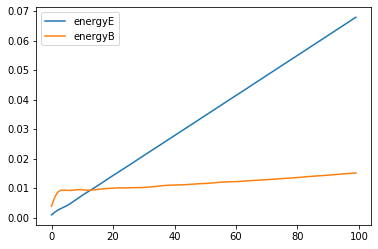

In [34]:
import matplotlib.pyplot as plt

plt.plot (energyE)
plt.plot (energyB)
plt.plot (energytrace)
plt.plot (energySym)
plt.legend (["energyE", "energyB", "energytrace", "energySym"])
plt.show()